# Logistické a ML-based regresní modely

## Zadání úlohy 1

* Úkolem je vytvořit modely binární klasifikace na základě datasetů **Diabetes** a **Framingham**.
* Použité metody:
    * Logistická regrese
    * Rozhodovací strom (Decision tree)
    * Random Forest
* Vyhodnocení modelů pomocí ROC analýzy a Confusion Matrix

## Postup řešení

1. Načtěte dataset a proveďte jeho prozkoumání (např. pomocí df.info() a df.describe()).
2. Předzpracujte data:
    * Normalizujte numerické atributy pomocí **StandardScaler**.
    * Zpracujte chybějící hodnoty (např. odstranění nebo imputace).
    * Rozdělte data na trénovací a testovací sadu (70:30).
3. Vytvořte a natrénujte tři modely:
    * Logistickou regresi
    * Rozhodovací strom
    * Random Forest
4. Proveďte predikce na testovacích datech.
5. Vyhodnoťte modely pomocí následujících metrik:
    * **Confusion Matrix** – porovnání skutečných a predikovaných hodnot.
    * **ROC křivka a AUC** – srovnání výkonu modelů
    * **Přesnost, citlivost, F1-skóre** – výpočet klíčových metrik.
6. Diskutujte výsledky a srovnejte výkonnost modelů.

## Import and config

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, auc, accuracy_score, precision_score, 
                           recall_score, f1_score)

plt.style.use('default')
sns.set_style("whitegrid")


## Utility Functions

In [2]:
def load_and_explore_dataset(filepath, dataset_name):
    """Load and explore dataset"""
    print(f"\n{'='*50}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    df = pd.read_csv(filepath)
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nDataset Description:")
    print(df.describe())
    
    print("\nFirst 10 rows:")
    print(df.head(10))
    
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for column, count in missing_values.items():
        if count > 0:
            print(f"{column}: {count}")
    
    return df


In [3]:
def preprocess_data(df, target_column):
    """Preprocess data: handle missing values, normalize, split"""
    print(f"\nPreprocessing data...")
    
    # Handle missing values by removing rows with NaN
    df_clean = df.dropna()
    print(f"Rows after removing NaN: {len(df_clean)} (removed {len(df) - len(df_clean)})")
    
    # Separate features and target
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    
    # Split data (70:30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Normalize features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set size: {X_train_scaled.shape}")
    print(f"Test set size: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test


In [4]:
def train_models(X_train, y_train):
    """Train three classification models"""
    print("\nTraining models...")
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models


In [5]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate single model and return metrics"""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return metrics


In [6]:
def plot_confusion_matrix(y_test, y_pred, model_name, dataset_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Class 0", "Class 1"], 
                yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}\n{dataset_name}")
    plt.tight_layout()
    plt.show()


In [7]:
def plot_roc_curves(models_metrics, dataset_name):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(8, 6))
    
    for model_name, metrics in models_metrics.items():
        plt.plot(metrics['fpr'], metrics['tpr'], lw=2, 
                label=f'{model_name} (AUC = {metrics["auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves Comparison - {dataset_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [8]:
def print_metrics_summary(models_metrics, dataset_name):
    """Print summary of all metrics"""
    print(f"\n{'='*60}")
    print(f"METRICS SUMMARY - {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Create summary DataFrame
    summary_data = []
    for model_name, metrics in models_metrics.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics['accuracy']:.3f}",
            'Precision': f"{metrics['precision']:.3f}",
            'Recall': f"{metrics['recall']:.3f}",
            'F1-Score': f"{metrics['f1_score']:.3f}",
            'AUC': f"{metrics['auc']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))


## Dataset Configuration

In [9]:
# Dataset configurations
datasets_config = {
    'diabetes': {
        'filepath': 'datasets/diabetes.csv',
        'target': 'Outcome'
    },
    'framingham': {
        'filepath': 'datasets/framingham.csv', 
        'target': 'TenYearCHD'
    }
}

results = {}


## Analysis: Diabetes Dataset

In [10]:
dataset_name = 'diabetes'
config = datasets_config[dataset_name]

try:
    print(f"Starting analysis for {dataset_name}...")
    
    # Load and explore
    df_diabetes = load_and_explore_dataset(config['filepath'], dataset_name)
    
except FileNotFoundError:
    print(f"File not found: {config['filepath']}")


Starting analysis for diabetes...

DATASET: DIABETES

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Dataset Description:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000

In [11]:
# Preprocess diabetes data
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = preprocess_data(
    df_diabetes, config['target']
)



Preprocessing data...
Rows after removing NaN: 768 (removed 0)
Training set size: (537, 8)
Test set size: (231, 8)


In [12]:
# Train models for diabetes
trained_models_diabetes = train_models(X_train_diabetes, y_train_diabetes)



Training models...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...


### Diabetes - Model Evaluation


Evaluating Logistic Regression...

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       150
           1       0.68      0.52      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.74      0.74      0.74       231



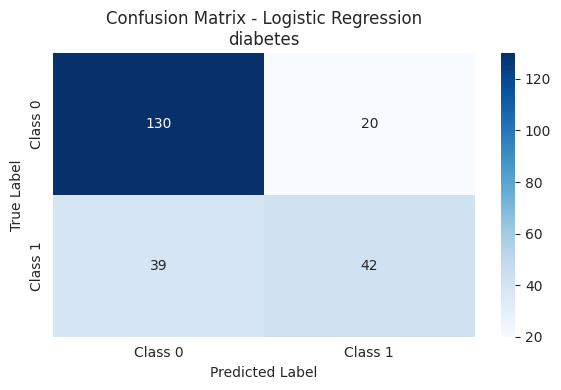


Evaluating Decision Tree...

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       150
           1       0.70      0.56      0.62        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.76      0.75       231



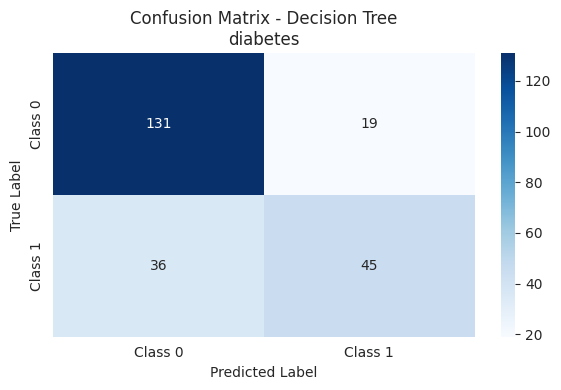


Evaluating Random Forest...

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       150
           1       0.69      0.54      0.61        81

    accuracy                           0.75       231
   macro avg       0.73      0.70      0.71       231
weighted avg       0.75      0.75      0.75       231



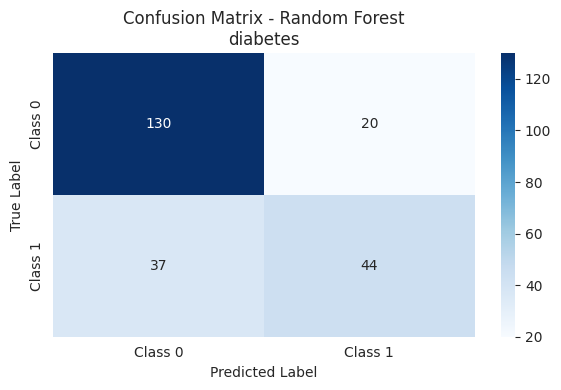

In [13]:
# Evaluate diabetes models
models_metrics_diabetes = {}

for model_name, model in trained_models_diabetes.items():
    print(f"\nEvaluating {model_name}...")
    metrics = evaluate_model(model, X_test_diabetes, y_test_diabetes, model_name)
    models_metrics_diabetes[model_name] = metrics
    
    # Print classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_test_diabetes, metrics['y_pred']))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test_diabetes, metrics['y_pred'], model_name, dataset_name)


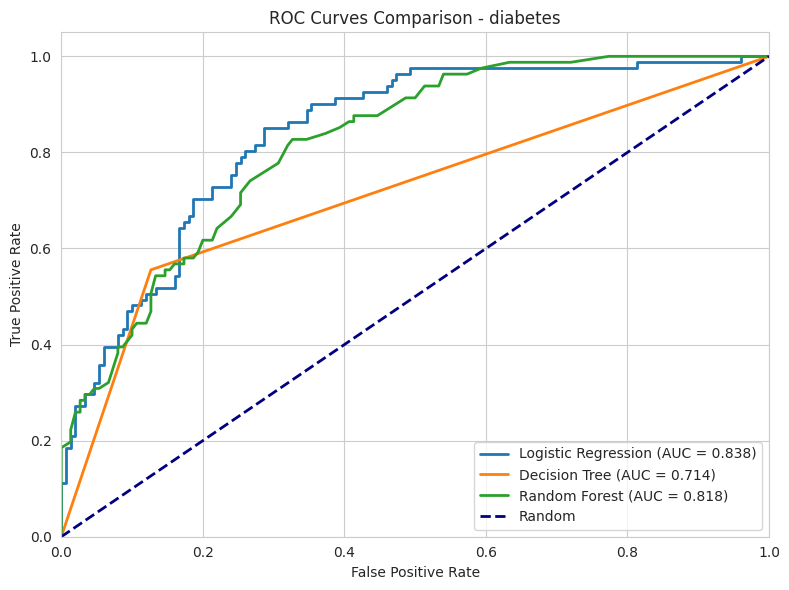

In [14]:
# Plot ROC curves comparison for diabetes
plot_roc_curves(models_metrics_diabetes, dataset_name)


In [15]:
# Print metrics summary for diabetes
print_metrics_summary(models_metrics_diabetes, dataset_name)
results[dataset_name] = models_metrics_diabetes



METRICS SUMMARY - DIABETES
              Model Accuracy Precision Recall F1-Score   AUC
Logistic Regression    0.745     0.677  0.519    0.587 0.838
      Decision Tree    0.762     0.703  0.556    0.621 0.714
      Random Forest    0.753     0.688  0.543    0.607 0.818


## Analysis: Framingham Dataset

In [16]:
dataset_name = 'framingham'
config = datasets_config[dataset_name]

try:
    print(f"Starting analysis for {dataset_name}...")
    
    # Load and explore
    df_framingham = load_and_explore_dataset(config['filepath'], dataset_name)
    
except FileNotFoundError:
    print(f"File not found: {config['filepath']}")


Starting analysis for framingham...

DATASET: FRAMINGHAM

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   i

In [17]:
# Preprocess framingham data
X_train_framingham, X_test_framingham, y_train_framingham, y_test_framingham = preprocess_data(
    df_framingham, config['target']
)



Preprocessing data...
Rows after removing NaN: 3656 (removed 582)
Training set size: (2559, 15)
Test set size: (1097, 15)


In [18]:
# Train models for framingham
trained_models_framingham = train_models(X_train_framingham, y_train_framingham)



Training models...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...


### Framingham - Model Evaluation


Evaluating Logistic Regression...

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       930
           1       0.77      0.10      0.18       167

    accuracy                           0.86      1097
   macro avg       0.82      0.55      0.55      1097
weighted avg       0.85      0.86      0.81      1097



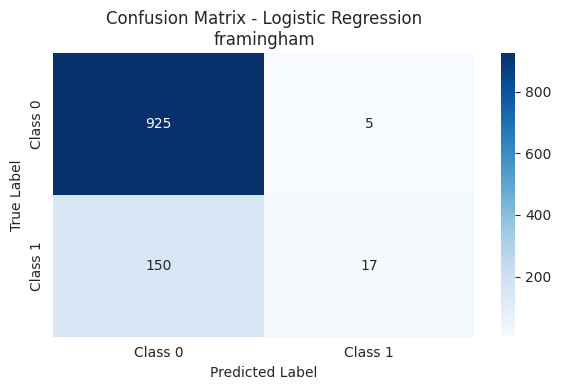


Evaluating Decision Tree...

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       930
           1       0.25      0.31      0.28       167

    accuracy                           0.75      1097
   macro avg       0.56      0.57      0.56      1097
weighted avg       0.78      0.75      0.76      1097



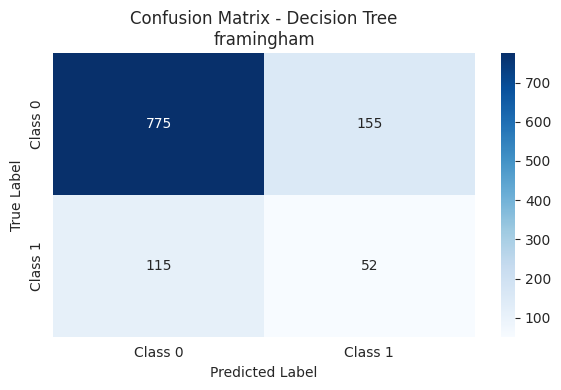


Evaluating Random Forest...

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       930
           1       0.73      0.07      0.12       167

    accuracy                           0.85      1097
   macro avg       0.79      0.53      0.52      1097
weighted avg       0.84      0.85      0.80      1097



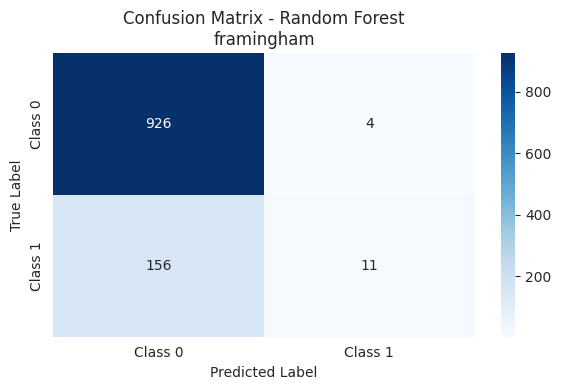

In [19]:
# Evaluate framingham models
models_metrics_framingham = {}

for model_name, model in trained_models_framingham.items():
    print(f"\nEvaluating {model_name}...")
    metrics = evaluate_model(model, X_test_framingham, y_test_framingham, model_name)
    models_metrics_framingham[model_name] = metrics
    
    # Print classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_test_framingham, metrics['y_pred']))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test_framingham, metrics['y_pred'], model_name, dataset_name)


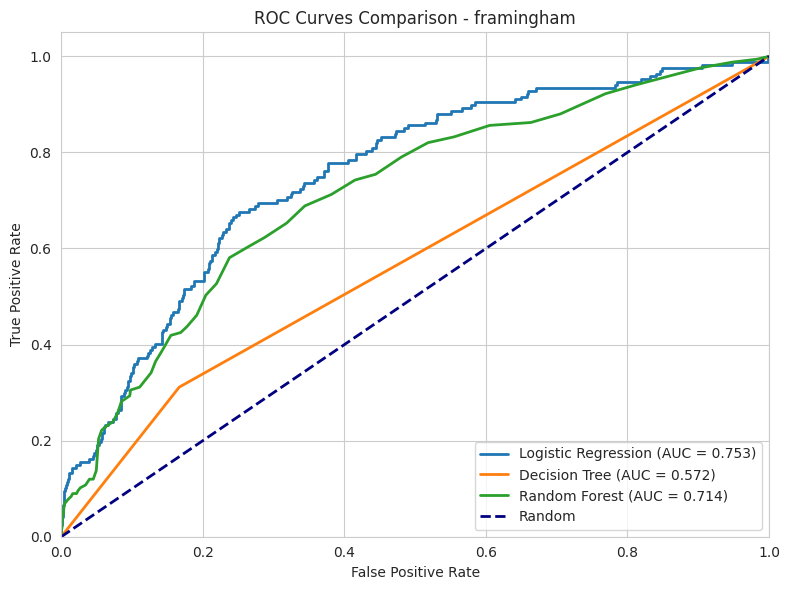

In [20]:
# Plot ROC curves comparison for framingham
plot_roc_curves(models_metrics_framingham, dataset_name)


In [21]:
# Print metrics summary for framingham
print_metrics_summary(models_metrics_framingham, dataset_name)
results[dataset_name] = models_metrics_framingham



METRICS SUMMARY - FRAMINGHAM
              Model Accuracy Precision Recall F1-Score   AUC
Logistic Regression    0.859     0.773  0.102    0.180 0.753
      Decision Tree    0.754     0.251  0.311    0.278 0.572
      Random Forest    0.854     0.733  0.066    0.121 0.714


## Final Comparison Across Datasets

In [22]:
print(f"{'='*80}")
print("FINAL COMPARISON ACROSS DATASETS")
print(f"{'='*80}")

for dataset_name, models_metrics in results.items():
    print(f"\nBest performing models for {dataset_name.upper()}:")
    best_auc = max(models_metrics.values(), key=lambda x: x['auc'])
    best_f1 = max(models_metrics.values(), key=lambda x: x['f1_score'])
    
    best_auc_model = [name for name, metrics in models_metrics.items() 
                     if metrics['auc'] == best_auc['auc']][0]
    best_f1_model = [name for name, metrics in models_metrics.items() 
                    if metrics['f1_score'] == best_f1['f1_score']][0]
    
    print(f"  Highest AUC: {best_auc_model} ({best_auc['auc']:.3f})")
    print(f"  Highest F1-Score: {best_f1_model} ({best_f1['f1_score']:.3f})")

print("\nAnalysis completed successfully!")


FINAL COMPARISON ACROSS DATASETS

Best performing models for DIABETES:
  Highest AUC: Logistic Regression (0.838)
  Highest F1-Score: Decision Tree (0.621)

Best performing models for FRAMINGHAM:
  Highest AUC: Logistic Regression (0.753)
  Highest F1-Score: Decision Tree (0.278)

Analysis completed successfully!


## Diskuze a závěry

Analýza hodnotí tři klasifikační algoritmy na dvou medicínských datasetech s odlišnou strukturou tříd a rozdílným výkonnostním profilem.

### Hlavní zjištění:

1. **Porovnání výkonu na datasetech**:
   - **Diabetes**: Dataset s mírnou nerovnováhou tříd (150:81).  
     - Nejvyšší AUC dosahuje logistická regrese (0.838).  
     - Nejvyšší F1 skóre vykazuje rozhodovací strom (0.621).
   - **Framingham**: Výrazná nerovnováha (930:167) negativně ovlivňuje výsledky.  
     - Nejvyšší AUC má opět logistická regrese (0.753).  
     - F1 skóre je nízké napříč modely, maximum dosahuje rozhodovací strom (0.278).

2. **Dopad nerovnováhy tříd**:
   - Framingham dataset vykazuje výrazný pokles výkonu kvůli nepoměru tříd (5.5:1).
   - Všechny modely selhávají v detekci menšinové třídy (pozitivní CHD).
   - Vysoká přesnost (85–86 %) odráží zaujatost ve prospěch většinové třídy.

3. **Pozorování k jednotlivým modelům**:
   - **Logistická regrese**:  
     - Stabilně dosahuje nejvyšší AUC.  
     - Nabízí dobře kalibrované pravděpodobnostní výstupy.  
     - Nerovnováhu zvládá lépe než stromové metody.
   - **Rozhodovací strom**:  
     - Nejlepší F1 skóre u diabetu.  
     - Výhodou je interpretovatelnost rozhodnutí.  
     - Výrazně trpí nerovnováhou ve Framinghamu.
   - **Random Forest**:  
     - Výkon neodpovídá očekáváním.  
     - Model je příliš konzervativní vůči menšinové třídě.

4. **Výkon v medicínském kontextu**:
   - **Diabetes**: Modely dosahují přijatelných hodnot F1 (0.587–0.621).
   - **CHD**: Výrazně nízká citlivost (0.066–0.311) signalizuje selhání v detekci rizikových pacientů.

### Kritické problémy:

1. Nerovnováha tříd u Framinghamu vyžaduje cílené metody zpracování.
2. Nízká citlivost na menšinovou třídu představuje klinické riziko.
3. Použití přesnosti jako metriky je zavádějící; vhodnější jsou F1 a AUC.